In [22]:
import warnings
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as statsmodels

from pandas import DataFrame, Series
from typing import Optional
from datetime import datetime

warnings.filterwarnings("ignore")


In [23]:
URL = (
    "https://course-resources.minerva.edu/uploaded_files/mu/00294342-2873/diabetes.csv"
)

X = "SkinThickness"
Xs = ["SkinThickness", "Glucose", "BloodPressure"]

Y = "BMI"


In [24]:
def preprocess_df(df: DataFrame) -> DataFrame:
    """
    Preprocesses the DataFrame by removing rows with 0 values for the columns
    of interest.
    """

    df = df[(df[X] != 0) & (df[Y] != 0)]
    for x in Xs:
        df = df[df[x] != 0]

    return df


In [25]:
def get_figure_filename(name: str) -> str:
    """Returns a filename for a figure based on the current time and the given name."""

    now = datetime.now()
    return f"figures/{now.strftime('%Y%m%d%H%M%S')}-{name}.png"


In [26]:
df = preprocess_df(pd.read_csv(URL))


In [28]:
summary = df[[X, Y]].describe().T[["mean", "std", "min", "max"]]
summary["mode"] = df[[X, Y]].mode().T
summary["median"] = df[[X, Y]].median().T
summary["range"] = summary["max"] - summary["min"]
summary = summary[["mean", "std", "mode", "median", "min", "max", "range"]]
summary = summary.T
print(summary)


        SkinThickness        BMI
mean        29.182331  32.890226
std         10.523878   6.881109
mode        32.000000  32.000000
median      29.000000  32.800000
min          7.000000  18.200000
max         99.000000  67.100000
range       92.000000  48.900000


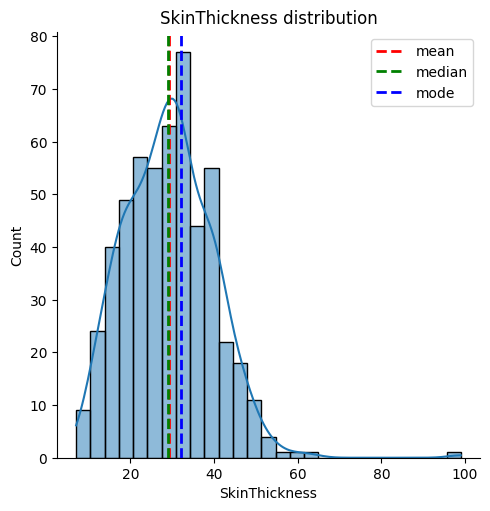

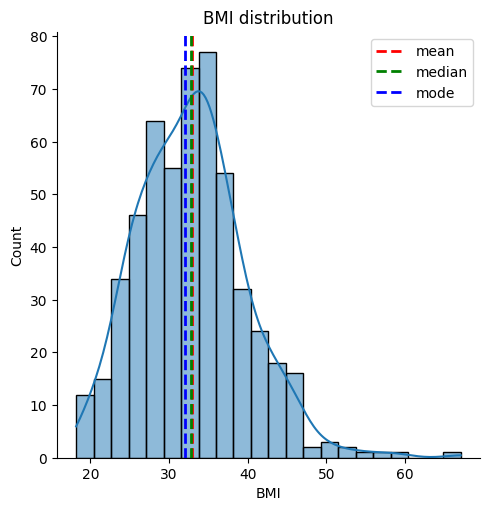

In [29]:
def plot_distribution(x: Series, name: Optional[str] = None):
    """Plots (and saves) a distribution plot for the given Series."""

    sns.displot(x, kde=True)

    plt.axvline(x.mean(), color="red", label="mean", linestyle="--", linewidth=2)
    plt.axvline(x.median(), color="green", label="median", linestyle="--", linewidth=2)
    plt.axvline(x.mode()[0], color="blue", label="mode", linestyle="--", linewidth=2)

    plt.title(f"{x.name} distribution")
    plt.legend()
    plt.savefig(get_figure_filename(name or "distribution"), dpi=600)
    plt.show()


plot_distribution(df[X], name="skin-thickness-histogram")
plot_distribution(df[Y], name="bmi-histogram")


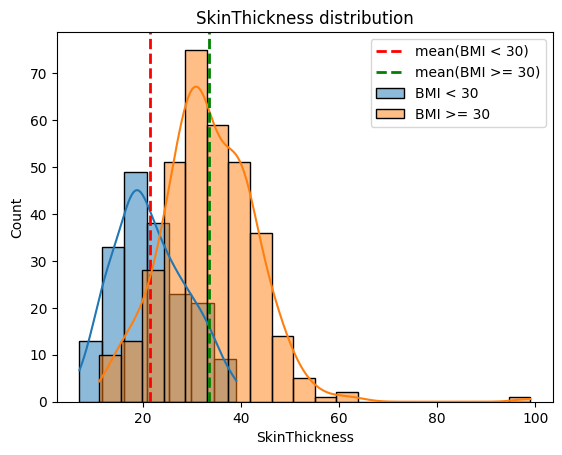

In [41]:
BINS = 20
Y_THRESHOLD = 30

control = df[df[Y] < Y_THRESHOLD]
treatment = df[df[Y] >= Y_THRESHOLD]

control_range = control[X].max() - control[X].min()
treatment_range = treatment[X].max() - treatment[X].min()
max_range = max(control_range, treatment_range)
control_bins = round(control_range / max_range * BINS)
treatment_bins = round(treatment_range / max_range * BINS)

sns.histplot(
    control[X],
    label=f"{Y} < {Y_THRESHOLD}",
    bins=control_bins,
    kde=True,
    # ax=ax,
)

plt.axvline(
    control[X].mean(),
    color="red",
    label=f"mean({Y} < {Y_THRESHOLD})",
    linestyle="--",
    linewidth=2,
)

sns.histplot(
    treatment[X],
    label=f"{Y} >= {Y_THRESHOLD}",
    bins=treatment_bins,
    kde=True,
    # ax=ax,
)

plt.axvline(
    treatment[X].mean(),
    color="green",
    label=f"mean({Y} >= {Y_THRESHOLD})",
    linestyle="--",
    linewidth=2,
)

plt.title(f"{control[X].name} distribution")
plt.legend()

# plt.savefig("figure3.png", dpi=600)
plt.show()


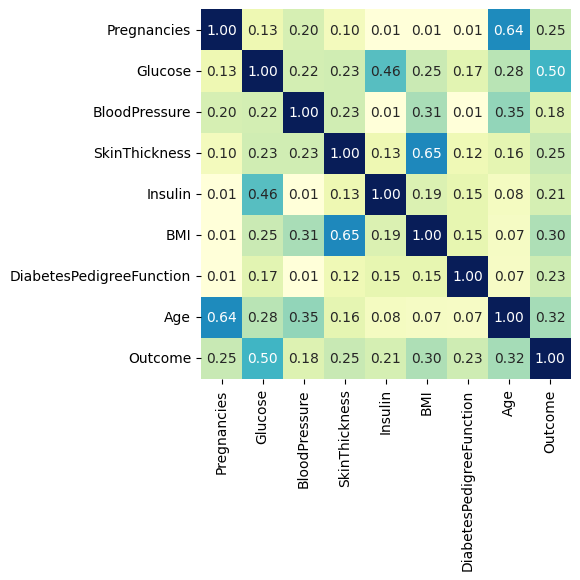

In [31]:
def plot_correlation_matrix(df: DataFrame, name: Optional[str] = None):
    """Plots (and saves) a correlation matrix for the given DataFrame."""

    sns.heatmap(
        df.corr().abs(),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        cbar=False,
        square=True,
    )

    plt.savefig(get_figure_filename(name or "correlation-matrix"), dpi=600)
    plt.show()


plot_correlation_matrix(df, name="correlation-matrix")


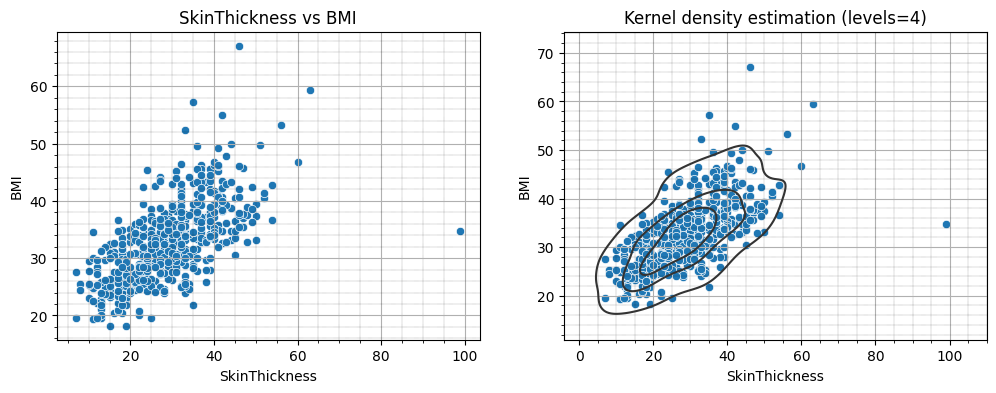

In [45]:
def plot_scatter(x: Series, y: Series, name: Optional[str] = None):
    """Plots (and saves) a scatter plot for the given Series."""

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

    ax1.grid(True)
    ax1.minorticks_on()
    ax1.grid(which="minor", linestyle=":", linewidth="0.25", color="black")
    ax1.set_title(f"{x.name} vs {y.name}")
    sns.scatterplot(x=x, y=y, ax=ax1)

    ax2.grid(True)
    ax2.minorticks_on()
    ax2.grid(which="minor", linestyle=":", linewidth="0.25", color="black")
    ax2.set_title(f"Kernel density estimation (levels=4)")
    sns.scatterplot(x=x, y=y, ax=ax2)
    sns.kdeplot(x=x, y=y, ax=ax2, levels=4, color=".2")

    plt.savefig(get_figure_filename(name or "scatter"), dpi=600)
    plt.show()


plot_scatter(df[X], df[Y], name="scatter")


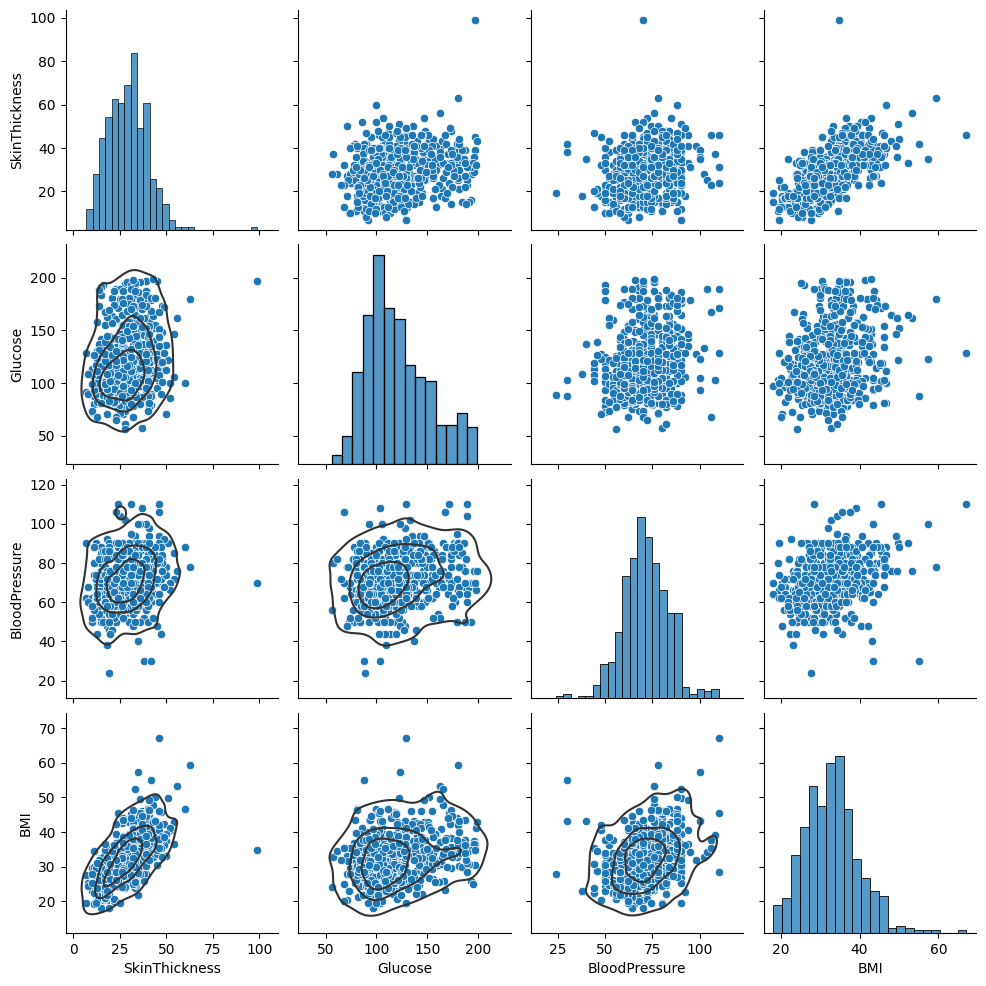

In [49]:
def plot_scatter_matrix(df: DataFrame, name: Optional[str] = None):
    """Plots (and saves) a scatter matrix for the given DataFrame."""

    plot = sns.pairplot(df)
    plot.map_lower(sns.kdeplot, levels=4, color=".2")

    plt.savefig(get_figure_filename(name or "scatter-matrix"), dpi=600)
    plt.show()


plot_scatter_matrix(df[[*Xs, Y]], name="pair-scatter")
# plot_scatter_matrix(df, name="pair-scatter")


                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     382.5
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           1.60e-64
Time:                        14:09:22   Log-Likelihood:                -1636.0
No. Observations:                 532   AIC:                             3276.
Df Residuals:                     530   BIC:                             3285.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.5367      0.671     30.587

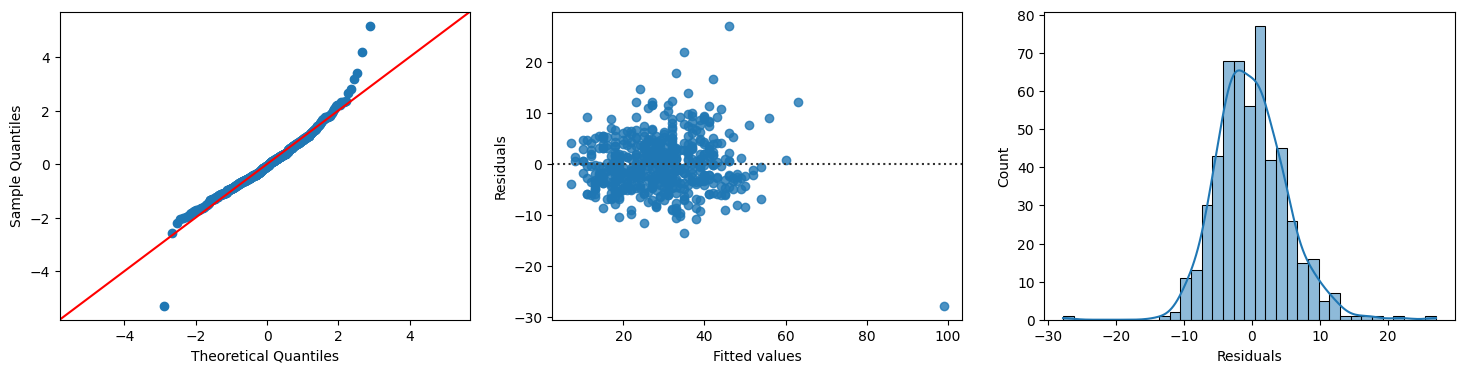

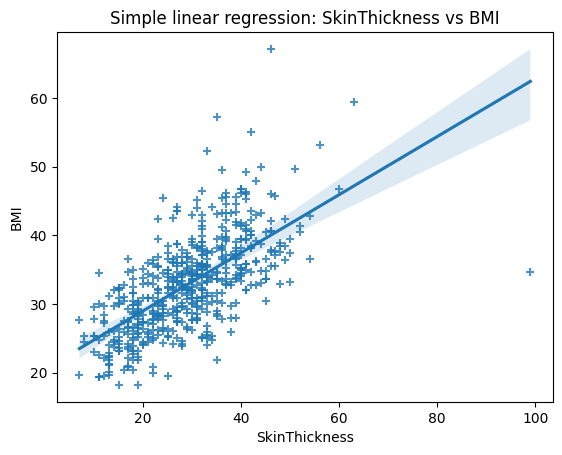

r=0.647422386296872 r_squared=0.4191557462783363, b_0=20.536716937994594, b_1=0.42332151941944396


In [60]:
def simple_regression(
    x: Series,
    y: Series,
    plot: bool = False,
    plot_name: Optional[str] = None,
    summary: bool = False,
) -> tuple[float, float, float]:
    """Performs a simple regression on the given Series and returns the R^2, b_0, and b_1."""

    _x = statsmodels.add_constant(x)
    model = statsmodels.OLS(y, _x)
    results = model.fit()

    if summary:
        print(results.summary())

    residuals = results.resid
    r_squared = results.rsquared
    b_0, b_1 = results.params

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 4))

        # ax1: scatter
        statsmodels.qqplot(residuals, fit=True, line="45", ax=ax1)

        # ax2: residuals
        sns.residplot(x=x, y=y, ax=ax2)
        ax2.set(
            ylabel="Residuals",
            xlabel="Fitted values",
        )

        # ax3: histogram
        sns.histplot(residuals, kde=True, ax=ax3)
        ax3.set(xlabel="Residuals")

        plt.savefig(get_figure_filename(plot_name or "simple-regression"), dpi=600)
        plt.show()

        sns.regplot(
            x=x,
            y=y,
            marker="+",
        )
        plt.title(f"Simple linear regression: {x.name} vs {y.name}")

        plt.savefig(
            get_figure_filename(plot_name or "simple-regression-regplot"), dpi=600
        )
        plt.show()

    return r_squared, b_0, b_1


r, _ = stats.pearsonr(df[X], df[Y])
r_squared, b_0, b_1 = simple_regression(
    df[X], df[Y], plot=True, summary=True, plot_name="simple-regression"
)

print(f"{r=} {r_squared=}, b_0={b_0}, b_1={b_1}")


In [78]:
def multiple_regression(
    x,
    y: Series,
    plot: bool = False,
    plot_name: Optional[str] = None,
    summary: bool = False,
) -> tuple[float, float, list[float]]:
    """Performs a multiple regression on the given Series and returns the adjusted R^2, b_0, and b_1."""

    x = statsmodels.add_constant(x)
    model = statsmodels.OLS(y, x)
    results = model.fit()

    if summary:
        print(results.summary())

    residuals = results.resid
    r_squared_adj = results.rsquared_adj
    b_0, *b = results.params

    y_hat = results.predict()

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 4))

        # ax1: qq
        statsmodels.qqplot(residuals, fit=True, line="45", ax=ax1)

        # ax2: residual
        sns.residplot(x=y_hat, y=residuals, ax=ax2)
        ax2.set(
            ylabel="Residuals",
            xlabel="Fitted values",
        )

        # ax3: histogram
        sns.histplot(residuals, kde=True, ax=ax3)
        ax3.set(xlabel="Residuals")

        plt.savefig(get_figure_filename(plot_name or "multiple-regression"), dpi=600)
        plt.show()

        # predictors_text = ", ".join(list(x.columns)[1:])  # type: ignore

        sns.regplot(
            x=y_hat,
            y=y,
            marker="+",
        )
        plt.xlabel(f"predicted {y.name}")
        plt.show()

    return r_squared_adj, b_0, b


xs=['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age', 'Outcome'] r_squared=0.48
                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     71.66
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           2.20e-72
Time:                        14:25:07   Log-Likelihood:                -1601.8
No. Observations:                 532   AIC:                             3220.
Df Residuals:                     524   BIC:                             3254.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025     

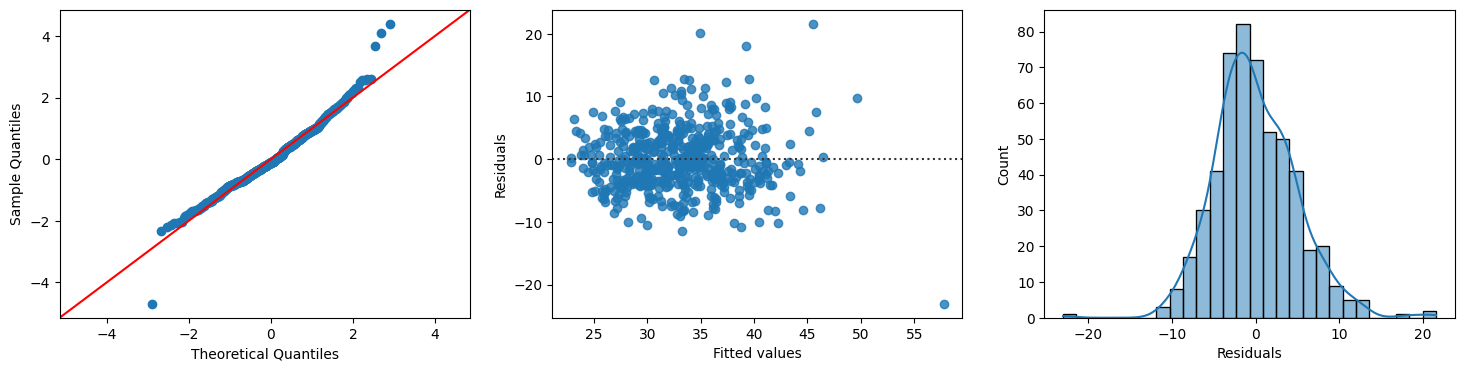

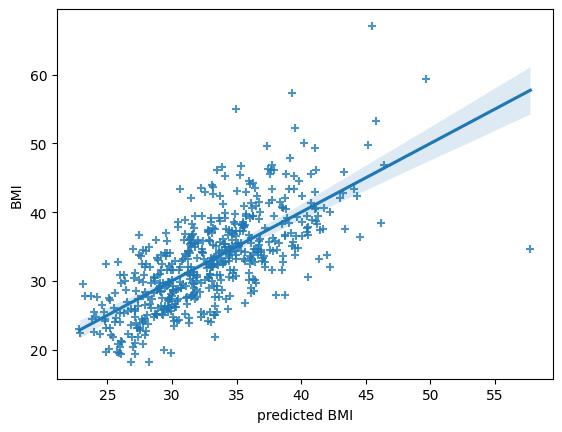

In [79]:
def forward_selection(
    df: DataFrame,
    xs: list[str],
    y: str,
) -> tuple[list[str], float, float, list[float]]:
    """Performs a forward selection on the given DataFrame and returns the best R^2, b_0, and b_1."""

    best_r_squared_adj = 0
    best_xs = None
    best_b_0 = None
    best_b = None

    for i in range(1, len(xs) + 1):
        for _xs in itertools.combinations(xs, i):
            r_squared_adj, b_0, b = multiple_regression(df[list(_xs)], df[y])
            if r_squared_adj > best_r_squared_adj:
                best_r_squared_adj = r_squared_adj
                best_xs = _xs
                best_b_0 = b_0
                best_b = b

    return best_xs, best_r_squared_adj, best_b_0, best_b  # type: ignore


columns: list[str] = list(df.columns)  # type: ignore
columns.remove(Y)

xs, r_squared, b_0, b = forward_selection(df, columns, Y)
xs = list(xs)

print(f"{xs=}", f"{r_squared=:.2f}")

# print(f"\\hat{{y}} = {b_0:.2f}", end="")
# for i, x in enumerate(xs):
#     print(f" + {b[i]:.2f} \\times {x}", end="")

r_squared, b_0, b = multiple_regression(
    df[xs], df[Y], plot=True, summary=True, plot_name="multiple-regression"
)


In [80]:
def standard_error(x: Series, y: Series, r_squared: float, ddof=1) -> float:
    """Calculates the standard error of the regression."""

    n = len(x)
    s_x = x.std(ddof=ddof)
    s_y = y.std(ddof=ddof)
    return (s_y / s_x) * np.sqrt((1 - r_squared) / (n - 2))


In [81]:
def p_value(x: Series, y: Series, beta_1: float, tails: int = 2) -> float:
    """Calculates the p-value of the regression."""

    r_squared, b_0, b_1 = simple_regression(x, y)
    SE_b_1 = standard_error(x, y, r_squared)

    t = (b_1 - beta_1) / SE_b_1

    print(f"{t=}")

    p: float = stats.t.sf(np.abs(t), len(x) - 2) * tails  # type: ignore

    return p


SE_b_1 = standard_error(df[X], df[Y], r_squared)
p = p_value(
    df[X],
    df[Y],
    0,
    tails=1,
)
print(f"{SE_b_1=} {p=}")


t=19.55671011502469
SE_b_1=0.020435916209150324 p=7.981331148295735e-65


In [82]:
def confidence_interval(
    x: Series, y: Series, alpha: float = 0.05
) -> tuple[float, float]:
    """Calculates the confidence interval of the regression."""

    r_squared, b_0, b_1 = simple_regression(x, y)
    SE_b_1 = standard_error(x, y, r_squared)

    t: float = stats.t.ppf(1 - alpha / 2, len(x) - 2)  # type: ignore

    print(f"{t=}")

    lower = b_1 - t * SE_b_1
    upper = b_1 + t * SE_b_1

    return lower, upper


ALPHA = 0.01
lower, upper = confidence_interval(df[X], df[Y], alpha=ALPHA)
print(f"{(1-ALPHA)*100:.2f}% [{lower=}, {upper=}]")


t=2.5851373418045815
99.00% [lower=0.3673640367444866, upper=0.47927900209440133]
